# Create Raw Data Tables

We'll extend our lakers analysis to all NBA teams by creating a data pipelines that'll ingest the raw data.

In the next notebook, we'll do some cleaning up and refinement to prepare for our analyses.

Instead of using Pandas, we'll be using Spark for data ingestion and transformations

## Import Packages

In [13]:
!pip install nba_api

In [14]:
import requests
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import pandas as pd

from bs4 import BeautifulSoup
import numpy as np
import nba_api
from nba_api.stats.endpoints import playerindex
from time import sleep

from google.colab import drive

sc = pyspark.SparkContext()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-2-eb4443ae3a43>:15 

In [18]:
import json
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting Data

In this notebook, we'll create our raw data tables for the following:

*   NBA Player Data
*   Team Schedule Results by Season
*   Team Box Score Results by Season





Write JSON out for player data


In [19]:
os.makedirs('/content/drive/MyDrive/NBA_Models', exist_ok=True)

players_json=json.loads(playerindex.PlayerIndex().get_json())

with open('/content/drive/MyDrive/NBA_Models/PlayerData.json', 'w') as f:
    json.dump(players_json, f)

In [22]:
columns=players_json['resultSets'][0]['headers']
columns

['PERSON_ID',
 'PLAYER_LAST_NAME',
 'PLAYER_FIRST_NAME',
 'PLAYER_SLUG',
 'TEAM_ID',
 'TEAM_SLUG',
 'IS_DEFUNCT',
 'TEAM_CITY',
 'TEAM_NAME',
 'TEAM_ABBREVIATION',
 'JERSEY_NUMBER',
 'POSITION',
 'HEIGHT',
 'WEIGHT',
 'COLLEGE',
 'COUNTRY',
 'DRAFT_YEAR',
 'DRAFT_ROUND',
 'DRAFT_NUMBER',
 'ROSTER_STATUS',
 'FROM_YEAR',
 'TO_YEAR',
 'PTS',
 'REB',
 'AST',
 'STATS_TIMEFRAME']

### Creating Spark Pipelines

In [6]:
spark = SparkSession.builder.appName("RawData").getOrCreate()

spark.read.json('/content/drive/MyDrive/NBA_Models/PlayerData.json').printSchema()

root
 |-- parameters: struct (nullable = true)
 |    |-- Active: string (nullable = true)
 |    |-- AllStar: string (nullable = true)
 |    |-- College: string (nullable = true)
 |    |-- Country: string (nullable = true)
 |    |-- DraftPick: string (nullable = true)
 |    |-- DraftYear: string (nullable = true)
 |    |-- Height: string (nullable = true)
 |    |-- Historical: string (nullable = true)
 |    |-- LeagueID: string (nullable = true)
 |    |-- PlayerPosition: string (nullable = true)
 |    |-- Season: string (nullable = true)
 |    |-- TeamID: string (nullable = true)
 |    |-- Weight: string (nullable = true)
 |-- resource: string (nullable = true)
 |-- resultSets: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- headers: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- rowSet: array (nullable = true)
 |    |    |    |-- element: array (contain

In [20]:
def players():
    df = spark.read \
    .format('json') \
    .options(header='true', inferSchema='true') \
    .load('/content/drive/MyDrive/NBA_Models/PlayerData.json')

    # Explode resultSets to access nested data
    df = df.select(explode("resultSets").alias("result"))

    # Extract rowSet
    df = df.select(col("result.rowSet").alias("rowSet"))

    # Convert the nested structure into rows for each player
    df = df.select(explode("rowSet").alias("player_data")) #column will be dropped later

    # Create columns dynamically based on the assumed structure of "player_data"
    for i, header in enumerate(columns):
        df = df.withColumn(header, df.player_data.getItem(i))

    # Create temporary view for SQL
    df.drop('player_data').createOrReplaceTempView("PlayerData")


In [23]:
players()
spark.sql("SELECT * FROM PlayerData").show()

+---------+----------------+-----------------+--------------------+----------+------------+----------+-----------+-------------+-----------------+-------------+--------+------+------+----------------+--------------+----------+-----------+------------+-------------+---------+-------+----+----+---+---------------+
|PERSON_ID|PLAYER_LAST_NAME|PLAYER_FIRST_NAME|         PLAYER_SLUG|   TEAM_ID|   TEAM_SLUG|IS_DEFUNCT|  TEAM_CITY|    TEAM_NAME|TEAM_ABBREVIATION|JERSEY_NUMBER|POSITION|HEIGHT|WEIGHT|         COLLEGE|       COUNTRY|DRAFT_YEAR|DRAFT_ROUND|DRAFT_NUMBER|ROSTER_STATUS|FROM_YEAR|TO_YEAR| PTS| REB|AST|STATS_TIMEFRAME|
+---------+----------------+-----------------+--------------------+----------+------------+----------+-----------+-------------+-----------------+-------------+--------+------+------+----------------+--------------+----------+-----------+------------+-------------+---------+-------+----+----+---+---------------+
|  1630173|         Achiuwa|         Precious|    precious

In [24]:
spark.sql("SELECT DISTINCT(TEAM_ABBREVIATION) FROM PlayerData").show(50)

+-----------------+
|TEAM_ABBREVIATION|
+-----------------+
|              GSW|
|              DET|
|              LAL|
|              NYK|
|              LAC|
|              UTA|
|              BOS|
|              TOR|
|              SAS|
|              POR|
|              DEN|
|              DAL|
|              CLE|
|              MIA|
|              OKC|
|              PHX|
|              MIN|
|              MEM|
|              SAC|
|              ATL|
|              PHI|
|              WAS|
|              NOP|
|              IND|
|              HOU|
|              CHA|
|              BKN|
|              CHI|
|              ORL|
|              MIL|
|             NULL|
+-----------------+



Since the website we're scraping data from uses different team abbreviations than the offical ones in their urls, we'll have to manually list them out

### Get team schedule results

In [25]:
teams = ['GSW',
'DET',
'LAL',
'NYK',
'LAC',
'UTA',
'BOS',
'TOR',
'SAS',
'POR',
'DEN',
'DAL',
'CLE',
'MIA',
'OKC',
'PHO',
'MIN',
'MEM',
'SAC',
'ATL',
'PHI',
'WAS',
'NOP',
'IND',
'HOU',
'CHO',
'BRK',
'CHI',
'ORL',
'MIL']

Get raw html table from the site we're extracting from

In [ ]:
base_url = "https://www.basketball-reference.com"

def get_schedule(team_id, year):
    """
    Scrapes basketball-reference.com for Lakers game data and returns a DataFrame.

    Args:
        team_id (str): The team abbreviation.
        year (str): The season year.

    Returns:
        spark.DataFrame: A DataFrame containing game data.
    """
    team_url = f"{base_url}/teams/{team_id}/{year}_games.html"

    response = requests.get(team_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch the {team_id} season page!")

    team_soup = BeautifulSoup(response.content, 'html.parser')
    box_score_table = team_soup.find('table', {'id': 'games'})

    box_score_links = []
    opps = []

    for row in box_score_table.find_all('tr'):
        box_score_cell = row.find('td', {'data-stat': 'box_score_text'})
        if box_score_cell and box_score_cell.find('a'):
            relative_link = box_score_cell.find('a')['href']
            box_score_links.append(f"{base_url}{relative_link}")
        opp_cell = row.find('td', {'data-stat': 'opp_name'})
        if opp_cell and opp_cell.find('a'):
            opps.append(opp_cell.find('a')['href'].split('/')[2])

    all_game_stats = []
    for url in box_score_links[:1]:
      response = requests.get(url)
      if response.status_code != 200:
          raise Exception("Failed to fetch box score stats!")
      box_soup = BeautifulSoup(response.content, 'html.parser')

      box_score_stats = box_soup.find('table', {'id': f'box-{team_id}-game-basic'})
      home_team = box_soup.title.string.split(',')[0].split('vs')[0].strip()

      box_score_df = pd.read_html(str(box_score_stats))[0].droplevel(0, axis=1)
      box_score_df['Game'] = box_score_links.index(url) + 1
      box_score_df['Home'] = 1 if home_team == 'Lakers' else 0
      box_score_df['Opponet'] = opps[box_score_links.index(url)]

      all_game_stats.append(box_score_df)
      sleep(5)

    df = pd.concat(all_game_stats, ignore_index=True)
    df = df.to_spark()
    return df

get_schedule('LAL', '2025').show()

In [28]:
base_url = "https://www.basketball-reference.com"
## Function that'll return schedules by team and year
def get_schedule(team_id, year):
    """
    Scrapes basketball-reference.com for Lakers game data that saves the html table
    to a Spark Temporary View and writes out the box score statistics for each game
    as a spark csv table.

    Args:
        team_id (str): The team abbreviation.
        year (str): The season year.
    """
    all_game_stats = []

    url = f"{base_url}/teams/{team_id}/{year}_games.html"
    response = requests.get(url)
    if response.status_code != 200:
      raise Exception(f"Failed to fetch the {team_id} season page!")
    sleep(5)

    team_soup = BeautifulSoup(response.content, 'html.parser')
    box_score_table = team_soup.find('table', {'id': 'games'})
    box_score_links = []
    opps = []

    for row in box_score_table.find_all('tr'):
        box_score_cell = row.find('td', {'data-stat': 'box_score_text'})
        if box_score_cell and box_score_cell.find('a'):
            relative_link = box_score_cell.find('a')['href']
            box_score_links.append(f"{base_url}{relative_link}")
        opp_cell = row.find('td', {'data-stat': 'opp_name'})
        if opp_cell and opp_cell.find('a'):
            opps.append(opp_cell.find('a')['href'].split('/')[2])

    all_game_stats = []
    for url in box_score_links:
      response = requests.get(url)
      if response.status_code != 200:
          break
      box_soup = BeautifulSoup(response.content, 'html.parser')

      box_score_stats = box_soup.find('table', {'id': f'box-{team_id}-game-basic'})
      home_team = box_soup.title.string.split(',')[0].split('vs')[0].strip()

      box_score_df = pd.read_html(str(box_score_stats))[0].droplevel(0, axis=1)
      box_score_df['Game'] = box_score_links.index(url) + 1
      box_score_df['Home'] = 1 if home_team == 'Lakers' else 0
      box_score_df['Opponet'] = opps[box_score_links.index(url)]

      all_game_stats.append(box_score_df)
      sleep(5)

    box_score_df = pd.concat(all_game_stats, ignore_index=True)
    box_score_df = box_score_df.to_spark()

    ## Write out data
    table_path = f'/content/drive/MyDrive/NBA_Models/Spark_DB/{team_id}_{year}_schedule_data.html'
    with open(table_path, 'w') as f:
      f.write(str(box_score_table))

    spark.read.\
    format('text').\
    load(table_path).\
    createOrReplaceTempView(f'{team_id}_{year}_schedule_html')

    df_path = f'/content/drive/MyDrive/NBA_Models/Spark_DB/{team_id}_{year}_box_data'
    box_score_df.write.format('csv').mode('overwrite').\
    option('headers', 'true').option('delimiter', ',').csv(df_path)

## test using Golden State Warriors for 2025 season
get_schedule('GSW', 2025)

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/namespace.py:1364: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pdfs = pd.read_html(
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/namespace.py:1364: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pdfs = pd.read_html(
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/namespace.py:1364: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pdfs = pd.read_html(
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/namespace.py:1364: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal

In [29]:
spark.read.\
  options(delimiter= ",").\
  format('csv').\
  load("/content/drive/MyDrive/NBA_Models/Spark_DB/GSW_2025_box_data").\
  show()

+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+----+----+
|                 _c0|          _c1|          _c2|          _c3|          _c4|          _c5|          _c6|          _c7|          _c8|          _c9|         _c10|         _c11|         _c12|         _c13|         _c14|         _c15|         _c16|         _c17|         _c18|         _c19|         _c20|         _c21|_c22|_c23|_c24|
+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+----+----+
|   

In [31]:
table_path = f'/content/drive/MyDrive/NBA_Models/Spark_DB/GSW_2025_schedule_data.html'

spark.read.\
  options(delimiter= "|").\
  format('text').\
  load(table_path).\
  createOrReplaceTempView('GSW_2025_schedule_html')

spark.sql("""
SELECT * FROM GSW_2025_schedule_html LIMIT 3
""").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                      |
+---------------------------------------------------------------------------------------------------------------------------+
|<table class="sortable stats_table" data-cols-to-freeze=",2" id="games">                                                   |
|<caption>Regular Season Table</caption>                                                                                    |
|<colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup>|
+---------------------------------------------------------------------------------------------------------------------------+



Now we need to extract the score results by game from the html table

In [32]:
spark.sql("""
WITH game_rows (row) AS (
    SELECT explode(split(value, '</tr>')) AS row
    FROM gsw_2025_schedule_html
),

extracted_data (row, pos, cell) AS (
    SELECT
        posexplode(split(row, '</td>')) AS (pos, cell),
        row
    FROM game_rows
)

SELECT * from extracted_data
""").show(truncate=False)


+---+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|row|pos                                                                                                                                |cell                                                                                                                               |
+---+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|0  |<table class="sortable stats_table" data-cols-to-freeze=",2" id="games">                                                           |<table class="sortable stats_table" data-cols-to-free

Should be easy, it just requires a simple regexpr function
For example, to extract the points scored we just copy and paste everything from  ```data-stat``` to ```</td>``` and look for the number that's in between.

It'll return as a string so we will apply an integer cast transformation

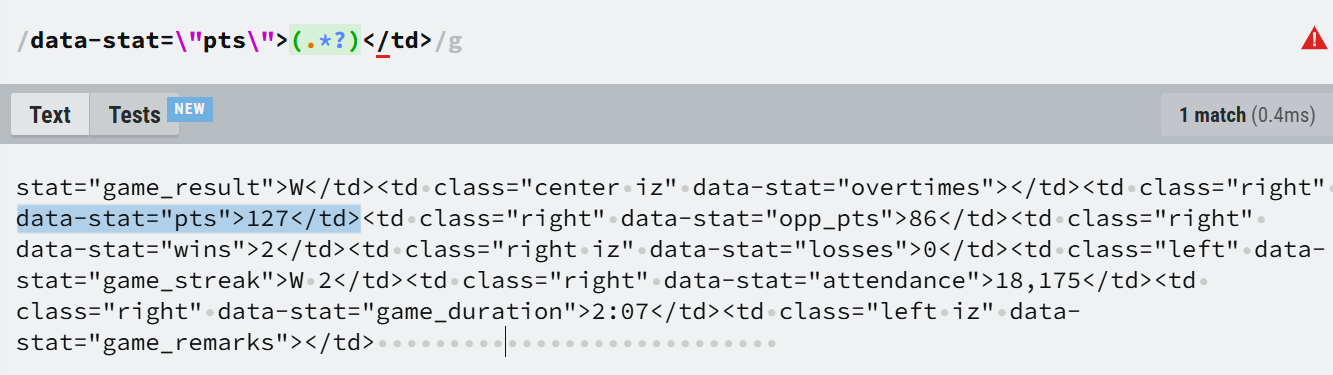

In [33]:
def create_schedule_table(team_id, year):
    """
    Takes the HTML data to find the score results for all games played and
    writes out results to a spark CSV table

    Args:
        team_id (str): The team abbreviation.
        year (str): The season year.
      """

    spark.sql(f"""
      WITH game_rows (row) AS (
          SELECT explode(split(value, '</tr>')) AS row
          FROM {team_id}_{year}_schedule_html
      ),

      extracted_data (row, pos, cell) AS (
          SELECT
              posexplode(split(row, '</td>')) AS (pos, cell),
              row
          FROM game_rows
      ),
      relevant_cells (row, points_for, points_against) AS (
      SELECT
      CAST(regexp_extract(cell, 'scope="row">([0-9]+)</th>') AS INT) AS game,
      CAST(regexp_extract(cell, 'data-stat=\"opp_pts\">([0-9]+)</td>') AS INT) AS points_for,
      CAST(regexp_extract(cell, 'data-stat=\"pts\">([0-9]+)</td>') AS INT) AS points_against
      FROM extracted_data)

      SELECT distinct(*) FROM relevant_cells
      WHERE row IS NOT NULL
      ORDER BY row ASC
      """).\
      write.format('csv').mode('overwrite').\
      option('headers', 'true').option('delimiter', ',').\
      save(f'/content/drive/MyDrive/NBA_Models/Spark_DB/{team_id}_{year}_schedule_data')
      #saveAsTable(f'/content/drive/MyDrive/NBA_Models/Spark_DB.{team_id}_{year}_schedule_data') ## Use this for databricks

create_schedule_table('GSW', 2025)
### Display table for Golden State Warriors 2025
read_schema=StructType([
  StructField("game", ShortType(), True),
  StructField("points_for", ShortType(), True),
  StructField("points_against", ShortType(), True)
  ])

spark.read.format('csv').\
csv('/content/drive/MyDrive/NBA_Models/Spark_DB/GSW_2025_schedule_data', schema=read_schema).\
show(50)

+----+----------+--------------+
|game|points_for|points_against|
+----+----------+--------------+
|   1|       104|           140|
|   2|        86|           127|
|   3|       112|           104|
|   4|       106|           124|
|   5|        89|           104|
|   6|       121|           127|
|   7|       112|           125|
|   8|       112|           118|
|   9|       136|           117|
|  10|       116|           127|
|  11|       117|           120|
|  12|       118|           123|
|  13|       102|            99|
|  14|        97|           120|
|  15|       108|           112|
|  16|       104|            94|
|  17|       128|           120|
|  18|       105|           101|
|  19|       113|           105|
|  20|       119|           115|
|  21|        93|            99|
|  22|       107|            90|
|  23|       106|           114|
|  24|        91|            90|
|  25|       143|           133|
|  26|       144|            93|
|  27|       103|           113|
|  28|    